In [1]:
%load_ext autoreload
%autoreload 2

# RL Part 2

In this part, I have learned a lot of new concepts and deepened my understanding of reinforcement learning through hands-on implementation. Initially, this was not the assignment I intended to submit. I began by attempting to recreate the DeepMind paper *"Exploring Faster Matrix Multiplication Algorithms with Reinforcement Learning"*.

I managed to implement most of the core components, including:
- the custom environment,
- the neural network architecture (Torso, Value Head, Policy Head),
- and the Monte Carlo Tree Search (MCTS) module, which served as the primary mechanism for exploring the state space in game-like environments.

However, integrating all these components into a working system proved to be complex. The final step—putting everything together—required significant tuning and debugging, which made it infeasible to complete within the current timeframe. As a result, I decided to postpone this ambitious task and instead focus on completing a more classical RL example for the assignment.

It is worth noting, though, that I have already grasped the key RL component of AlphaTensor, namely MCTS. The remaining challenge largely concerns architectural choices and making the model work reliably, which I plan to return to in the future.


## Continuous Control in Reinforcement Learning

In this notebook, I will use environments from the `gym` library, specifically the Lunar Lander, and a custom environment named `pushT`. The `pushT` environment is not part of the standard `gym` suite; I forked it from the Hugging Face repository and modified the vanilla version to incorporate additional functionalities, aligning it more closely with my task requirements.

The primary difference between the reinforcement learning (RL) approaches covered in the AP semester and Part 1 lies in the exploration of agent operations within continuous action spaces.

I will begin with stating my initial ideas and the rationale behind them, followed by a more formal definition of the tools and algorithms employed.

To navigate the environment successfully, the agent interacts through actions. The policy is a function $a = \pi(s)$ that takes the state as input and outputs actions. There are two ways to implement the policy:

1. **Deterministic Policy**: The function returns a single action.
2. **Stochastic Policy**: The function maps the state to a probability distribution over the action space.

The stochastic approach resembles Q-learning, where we had probabilities of actions given a state. This method intuitively represents exploration by sampling from a modified probability distribution (e.g., Boltzmann). From a mathematical perspective, representing the policy as a probability distribution is natural. However, from a computer science point of view, deterministic policies are more practical due to limitations in representing some abstract mathematical concepts within a computer system, in this case probability distributions.

Having committed to a deterministic policy, I have found the Deep Deterministic Policy Gradient (DDPG) algorithm, from the paper "Continuous Control with Deep Reinforcement Learning" (Lillicrap et al., 2016). The abstract of the paper described it as the solid foundation for my assignment:

> "We adapt the ideas underlying the success of Deep Q-Learning to the continuous action domain. We present an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action spaces. Using the same learning algorithm, network architecture and hyper-parameters, our algorithm robustly solves more than 20 simulated physics tasks, including classic problems such as cartpole swing-up, dexterous manipulation, legged locomotion and car driving."

## Deep Deterministic Policy Gradient (DDPG)

DDPG is an off-policy, model-free reinforcement learning algorithm tailored for environments with continuous action spaces. It use the deterministic policy gradient approach with strategies from Deep Q-Networks (DQN), such as experience replay and target networks, to enhance learning stability.

### Understanding Off-Policy Learning Through Q-Function Abstraction

During this assignment and exploring multiple different approaches, I have come to a deeper understanding of what off-policy learning truly entails—not just from the user perspective, but from the internal mechanics of the learning process. The key realization is that the policy can evolve over time, yet I can disregard the fact that actions were recorded under a different distribution because I utilize the Q-function. This function provides a level of abstraction that remains stable across the environment, ensuring that any optimal policy will converge to the same function, I have seen this in one of the papers called $Q_{\pi_*}$ the actual Q function that stabilizes under the optimal policy.

This abstraction allows the agent to be another function trained on this representation of the environment. If, instead, I had a training process without the Q-function—where the policy itself must encapsulate the knowledge of the environment—I would need to consider the sampling process more carefully. This is because, at the interpretative level, actions were taken based on a perception of the environment that changes as the policy evolves.

This distinction highlights the essence of model-based versus model-free learning, and more specifically, the difference between off-policy and on-policy methods. In off-policy learning, like with Q-learning, the environment is not encoded within the model. The learning process can utilize data generated from a different policy than the one currently being improved. This separation allows for greater flexibility and stability, as the learning of the value function (Q-function) is decoupled from the behavior policy used to collect data.

In contrast, on-policy methods require the policy being improved to be the same as the one used to collect data. This tight coupling necessitates that the policy must account for the environment's dynamics within itself, making the learning process more sensitive to changes in the policy and the environment.

By leveraging the Q-function in an off-policy framework, I can maintain a stable representation of the environment's dynamics, allowing for more robust and flexible policy learning that is less sensitive to the specific data collection policy.


### Core Components

- **Actor Network**: Represents the deterministic policy $\mu(s|\theta^\mu)$, mapping states to specific actions.

- **Critic Network**: Estimates the action-value function $Q(s,a|\theta^Q)$, evaluating the expected return of taking action $a$ in state $s$.

- **Target Networks**: Time-delayed copies of the actor and critic networks, denoted as $\mu'$ and $Q'$, respectively. These networks stabilize training by slowly tracking the learned networks.

- **Replay Buffer**: A memory bank $\mathcal{D}$ that stores past experiences $(s,a,r,s',d)$, enabling the reuse of data for learning and breaking correlations between sequential samples, that allows to form the independent batches and train nets in SGG way.

### Algorithmic Steps

1. **Initialization**:
   - Randomly initialize the actor and critic networks.
   $$
         \mu(s|\theta^\mu)
   $$
   $$
    Q(s,a|\theta^Q)
   $$
   - Initialize target networks to match the actual:
     $$
     \theta^{\mu'} \leftarrow \theta^\mu$, $\theta^{Q'} \leftarrow \theta^Q
     $$
   - Initialize the replay buffer
     $$
     \mathcal{D}
     $$.

2. **Interaction with Environment**:
   - At each time step, select an action using the current policy with added exploration noise: $a_t = \mu(s_t|\theta^\mu) + \mathcal{N}_t$.
   - Execute action $a_t$, observe reward $r_t$ and next state $s_{t+1}$.
   - Store the transition $(s_t, a_t, r_t, s_{t+1})$ in $\mathcal{D}$.

3. **Learning**:
   - Sample a minibatch of $N$ transitions $(s_i, a_i, r_i, s_{i+1}, d)$ from $\mathcal{D}$.
   - Compute target values:
     $$
     y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})
     $$
   - Update the critic by minimizing the MSE loss:
     $$
     L = \frac{1}{N} \sum_{i=1}^{N} \left( Q(s_i, a_i|\theta^Q) - y_i \right)^2
     $$
   - Update the actor using the sampled policy gradient:
     $$
     \nabla_{\theta^\mu} J \approx \frac{1}{N} \sum_{i=1}^{N} \nabla_a Q(s, a|\theta^Q)|_{s=s_i, a=\mu(s_i)} \nabla_{\theta^\mu} \mu(s|\theta^\mu)|_{s=s_i}
     $$
   - Update the target networks:
     $$
     \theta^{Q'} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q'}
     $$
     $$
     \theta^{\mu'} \leftarrow \tau \theta^\mu + (1 - \tau) \theta^{\mu'}
     $$
     where $\tau \ll 1$ is the soft update parameter.



This is the algorithm that I have used and implemented in this assignment, The actual code could be found in the `models.py`, the last thing that should be discussed to understand the first part is the Exploration.

### Exploration Strategy

Firstly I thought that since we have just vector and not the distribution over the actions, we will need some complicated way of adding the exploration, however it ended up being even easier, just adding noise to the action with mean of zero and reasonable variance is simple yet very efficient way to complete the given task.

Many articles and tutorials, including DDPG use a common choice of the Ornstein-Uhlenbeck process, which generates temporally correlated noise suitable for physical control problems.

# Lander

Initially I had multiple test runs and notebooks that was used to understand the domain of the RL problems. I figured out after the first run that the agent for PushT doesnt train. I decided to test my algorithms on the easier env from gym, particularly LunarLander with continuous action space

Luckily the training algorithm I have implemented DDPG doesnt requires any adjustments to be implemented on other envs.

In [2]:
import random
from AIA.rl.lander.models import Agent
import numpy as np

import gymnasium as gym

random.seed(0)

env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=True)

agent = Agent(alpha=1e-3, beta=1e-3, input_dims=8, tau=0.001,
              batch_size=256, n_actions=2, noise=0.15, expert_data=None)

np.random.seed(0)

score_history = []

In [16]:
for i in range(1000):
    obs, _ = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info, _ = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

    if i % 25 == 0:
        print(f'episode  {i}, 100 moving avg: {np.mean(score_history[-100:]):.2f}')

episode 0 | 100 eps moving avg : -42.585
episode 50 | 100 eps moving avg : -281.023
episode 100 | 100 eps moving avg : -234.579
episode 150 | 100 eps moving avg : -176.973
episode 200 | 100 eps moving avg : -177.340
episode 250 | 100 eps moving avg : -173.653
episode 300 | 100 eps moving avg : -123.264
episode 350 | 100 eps moving avg : -112.605
episode 400 | 100 eps moving avg : -132.281
episode 450 | 100 eps moving avg : -90.549
episode 500 | 100 eps moving avg : -63.476
episode 550 | 100 eps moving avg : -0.951
episode 600 | 100 eps moving avg : 52.958
episode 650 | 100 eps moving avg : 110.135
episode 700 | 100 eps moving avg : 193.135
episode 750 | 100 eps moving avg : 187.554
episode 800 | 100 eps moving avg : 174.381
episode 850 | 100 eps moving avg : 195.033
episode 900 | 100 eps moving avg : 198.626
episode 950 | 100 eps moving avg : 206.760


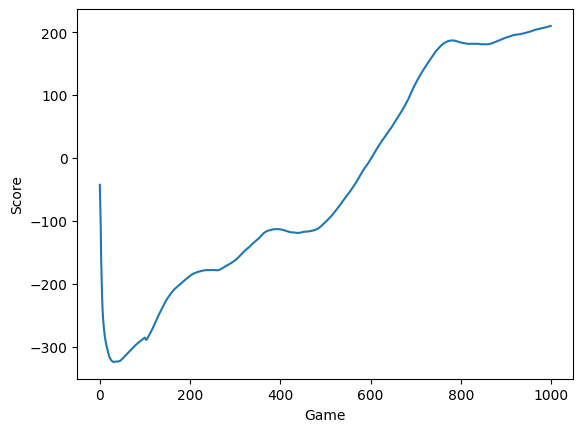

In [17]:
from AIA.rl.lander.plot import plot_learning_curve

plot_learning_curve(score_history, window=100)

# Push T test 1

After running tests on Lunar Lander and performing a small restructuring of the algorithm, I confirmed that the core logic is functioning correctly. Based on this, I decided to retest the algorithm on the PushT environment. The goal was to definitively assess whether the environment itself is inherently too complex for straightforward learning, and to determine if additional engineering tricks or architectural enhancements are necessary to achieve convergence.

In [3]:
from AIA.rl.lander.models import Agent
import numpy as np

from AIA.rl.lander.envs.pusht import PushTEnv

env = PushTEnv(render_mode="rgb_array")

agent = Agent(alpha=1e-3, beta=1e-3, noise=25, input_dims=5, tau=0.001,
              batch_size=64, n_actions=2)

In [4]:
score_history = []

For the PushT environment, I observed that the basic reward function can be misleading to the agent. For example, consider a situation where the agent manages to partially cover the target—say 50%. In this case, the agent receives a constant reward of 0.5 at every time step, even if it begins taking random or suboptimal actions. Since the reward signal remains positive, the agent falsely interprets these poor actions as beneficial. Worse, if the agent moves the object and only 30% of the target is covered, it still receives a reward of 0.3, which again does not reflect the deterioration of the task state.

To address this, I introduced a differential reward scheme: the agent now receives a reward proportional to the *change* in target coverage between steps. If its actions decrease the coverage, it incurs a penalty. This makes the reward signal more informative and aligned with actual task performance.

During training (with rendering enabled), I also noticed that the agent rarely moves the target object—this behavior is critical to task success and its absence is a problem. To counter this, I introduced an temporary reward that encourages movement of the object. This additional reward is scaled to avoid exploitation, ensuring the agent doesn't simply learn to move the target arbitrarily, but still receives incentive to explore actions that involve meaningful interaction with the object.


In [5]:
for i in range(10000):
    obs, _ = env.reset()
    done = False
    score = 0
    prev_reward = 0
    for t in range(400):
        act = agent.choose_action(obs)
        new_state, reward, done, info, _ = env.step(act)

        prev_t_pos = obs[2:3]
        new_t_pos = new_state[2:3]

        d_move = np.sqrt(np.sum((prev_t_pos - new_t_pos)**2))

        d_move_reward = d_move / 1000

        buffer_reward = reward

        reward -= prev_reward
        reward += d_move_reward

        prev_reward = buffer_reward

        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

    print(f'episode , {i} score {(score):3f} trailing 100 games avg {np.mean(score_history[-100:]):3f}' )


episode , 0 score 0.179083 trailing 100 games avg 0.179083
episode , 1 score 0.001149 trailing 100 games avg 0.090116
episode , 2 score 0.000000 trailing 100 games avg 0.060077
episode , 3 score 0.000000 trailing 100 games avg 0.045058
episode , 4 score 0.000000 trailing 100 games avg 0.036046
episode , 5 score 0.000000 trailing 100 games avg 0.030039
episode , 6 score 0.013157 trailing 100 games avg 0.027627
episode , 7 score 0.158390 trailing 100 games avg 0.043972
episode , 8 score 0.000000 trailing 100 games avg 0.039087
episode , 9 score 0.000000 trailing 100 games avg 0.035178
episode , 10 score 0.000000 trailing 100 games avg 0.031980
episode , 11 score 0.000000 trailing 100 games avg 0.029315
episode , 12 score 0.000000 trailing 100 games avg 0.027060
episode , 13 score 0.000000 trailing 100 games avg 0.025127
episode , 14 score 0.000000 trailing 100 games avg 0.023452
episode , 15 score 0.000000 trailing 100 games avg 0.021986
episode , 16 score 0.000000 trailing 100 games avg

KeyboardInterrupt: 

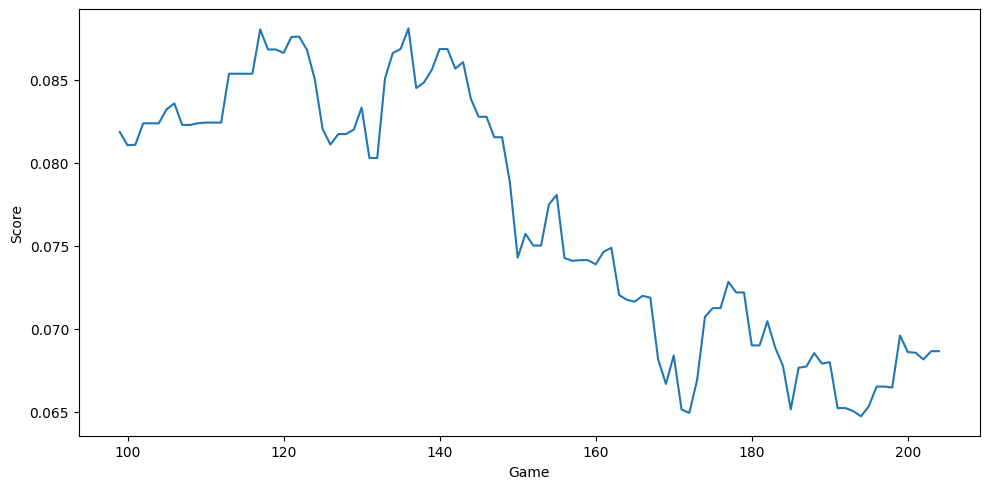

In [13]:
plot_learning_curve(score_history, window=100)

The agent does not learn effectively, primarily due to the high complexity of the environment. At the moment, only the first 200 episodes are displayed because I cleared the outputs earlier — however, the first training was actually running overnight for 10,000 episodes. Despite this extended training period, the observed improvements were minimal, indicating that either the current architecture or reward structure is insufficient to handle the intricacies of the task.


# Push T test 2

Here I have setup the env to record the demonstrations of successful push T trajectories. Also I have done research on the questions how to solve the problem of sparse rewards. I have found the paper named HER which is promising approach, which I will test in future.

In [ ]:
import torch
from torch import optim, nn
import pickle
from AIA.rl.lander.models import Agent
import numpy as np


In [ ]:
env = PushTEnv(obs_type="state", render_mode="rgb_array")
input_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

with open("demonstrations.pkl", "rb") as f:
    expert_transitions = pickle.load(f) # list of (s,a,r,s2,d)

agent = Agent(
        alpha=2e-4, beta=2e-4,
        input_dims=input_dim, n_actions=n_actions,
        tau=0.001, gamma=0.99,
        max_size=1_000_000, batch_size=256, noise=0.2,
        expert_data=expert_transitions,
        expert_ratio=0.25
)

## Pre-Train from expert

In [ ]:
def behaviour_clone(actor, demo, epochs=10, lr=1e-3, batch_size=256):
    device = actor.device
    opt    = optim.Adam(actor.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    N = len(demo)

    all_states = torch.tensor([t[0] for t in demo],
                              dtype=torch.float32, device=device)
    all_actions = torch.tensor([t[1] for t in demo],
                               dtype=torch.float32, device=device)

    actor.train()
    for ep in range(1, epochs+1):
        perm = torch.randperm(N, device=device)
        epoch_loss = 0.0

        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            states = all_states[idx]
            acts   = all_actions[idx]

            pred = actor(states)
            loss = loss_fn(pred, acts)

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item() * idx.size(0)

        avg_loss = epoch_loss / N
        if ep % max(1, epochs//10) == 0:
            print(f"[BC] Epoch {ep}/{epochs}, avg loss={avg_loss:.6f}")

    actor.eval()


def pre_train_critic(critic, demo, gamma=0.99, epochs=10, batch_size=256, lr=1e-3):
    device = critic.device
    opt    = optim.Adam(critic.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # compute returns G_t
    returns = []
    G = 0.0
    for (s,a,r,d,s2) in reversed(demo):
        if d:
            G = 0.0
        G = r + gamma * G
        returns.append(G)
    returns = returns[::-1]

    # pre‑stack tensors
    N = len(demo)
    states  = torch.tensor([t[0] for t in demo],
                           dtype=torch.float32, device=device)
    actions = torch.tensor([t[1] for t in demo],
                           dtype=torch.float32, device=device)
    targets = torch.tensor(returns,
                           dtype=torch.float32, device=device).unsqueeze(1)

    critic.train()
    for ep in range(1, epochs+1):
        perm = torch.randperm(N, device=device)
        epoch_loss = 0.0

        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            s_batch = states[idx]
            a_batch = actions[idx]
            y_batch = targets[idx]

            q_pred = critic(s_batch, a_batch)
            loss   = loss_fn(q_pred, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item() * idx.size(0)

        avg_loss = epoch_loss / N
        print(f"[Critic‑MC] Epoch {ep}/{epochs}, avg loss={avg_loss:.6f}")

    critic.eval()


Pre-train critic Network

In [ ]:
pre_train_critic(agent.critic,
                 demo=expert_transitions,
                 gamma=0.99,
                 epochs=200,
                 batch_size=256,
                 lr=1e-4)

Pre-train actor model

In [ ]:
behaviour_clone(agent.actor,
                demo=expert_transitions,
                epochs=2000,
                lr=1e-3)

## Testy Pre-train results

In [ ]:
import time

env =  PushTEnv(obs_type="state", render_mode="human")

obs, _ = env.reset()

for i in range(200):

    action = agent.choose_action(obs, eval=True)

    nxt, reward, terminated, truncated, _ = env.step(action)

    env.render()

    obs = nxt

    if terminated or truncated:
        break

env.close()

## Main Train

In [ ]:
score_history = []

In [ ]:
# env = PushTEnv(obs_type="state", render_mode="rgb_array")
env = PushTEnv(obs_type="state", render_mode="human")

In [ ]:
for ep in range(1, 10001):
    obs, _ = env.reset()
    done = False
    score = 0.0
    prev_reward = 0.0
    for i in range(200):
        env.render()
        action = agent.choose_action(obs)
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        prev_t_pos = obs[2:3]
        new_t_pos = new_state[2:3]

        d_move = np.sqrt(np.sum((prev_t_pos - new_t_pos)**2))

        d_move_reward = d_move / 1000

        buffer_reward = reward

        reward -= prev_reward
        reward += d_move_reward

        prev_reward = buffer_reward

        agent.memory.store_transition(obs, action, reward, new_state, done)
        agent.learn()

        obs = new_state
        score += reward

        if done:
            break

    score_history.append(score)
    if ep % 1 == 0:
        avg = np.mean(score_history[-100:])
        print(f"Episode {ep:5d}  Score: {score:.2f}  100‑ep avg: {avg:.2f}")

In [ ]:
env.close()

The basic methods didnt help with push T, This is because it is way more complicated, the agent is controlling itself and need to interact with the T, This includes understanding and transforming the state vector to one that will help to navigate and locate T, plan tasks to understand where to push the T, model the underlying physics. This requires more complicated approaches. I feel sad that I didnt start with this pushT assignment from the beggining, if that was I have succesffully demonstarated how I could solve the problems in this notebook. Definetely these tasks goes for the nearrest future, because I have found the task that is closely related to robotics tasks, also I have done a job to modify the env to better fit my future goals. And also I have started to collect the dataset of the expert demonstarations, that are going to be used in my research on Immitation learning and diffusion policy from expert demonstarations.

Also one of the approaches I have encountered is called her, I didnt have time to implement and test it here but I woild like to discuss it later. Its goal is to solve the rl problem of sparse rewards, by giving the agent chance to learn even on failure episodes, by pretending the goal was at the place where the episode ended.

I appreciete this assignment a lot, the field of rl amuse me with variety of tricks approaches and algorithms that engeniers discover to solve tasks.